INFO:__main__:Using device: cpu
/tmp/ipykernel_243486/3638075141.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_l

down_ratio = 4
loss_dict = {}


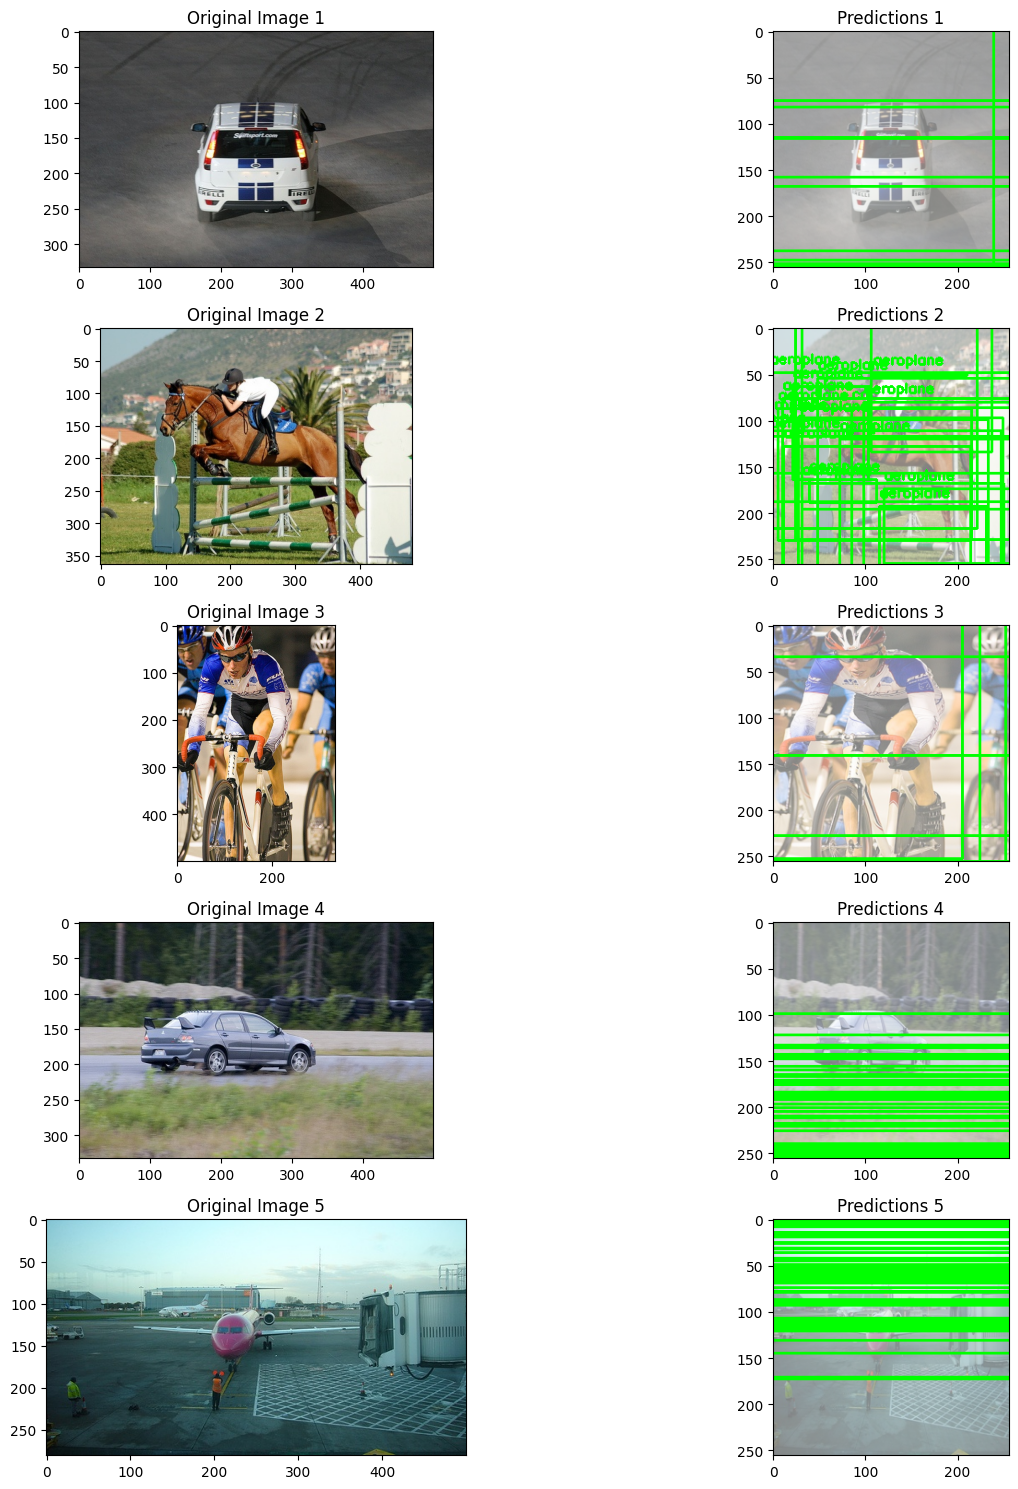

In [6]:
import os
import torch
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import custom modules
from training.encoder import CenternetEncoder

from utils.tmp_postprocess import CenternetPostprocess
from utils.tmp_visualizer import get_image_with_bboxes, PASCAL_CLASSES
from models.centernet import ModelBuilder, input_height, input_width
from data.dataset import Dataset

def prepare_dataset():
    """Prepare the validation dataset"""
    try:
        # Load VOC dataset
        dataset_val = torchvision.datasets.VOCDetection(root="../VOC", year='2007', image_set="train", download=False)
        dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)

        # Select first 30 indices for visualization
        indices = list(range(min(30, len(dataset_val))))
        dataset_val = Subset(dataset_val, indices)

        return dataset_val
    except Exception as e:
        logger.error(f"Error preparing dataset: {e}")
        raise

def create_transforms(input_height=256, input_width=256):
    """Create image transforms"""
    return transforms.Compose([
        transforms.Resize(size=(input_width, input_height)),
        transforms.ToTensor()
    ])

def load_trained_model(checkpoint_path, device):
    """Load the trained CenterNet model"""
    try:
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

        model = ModelBuilder(alpha=0.25).to(device)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.eval()
        return model
    except Exception as e:
        logger.error(f"Error loading model: {e}")
        raise


def visualize_predictions(model, dataset, transform, encoder, postprocessor, device, num_samples=5, confidence_threshold=0.3):
    """Visualize model predictions"""
    plt.figure(figsize=(15, 3*num_samples))

    for i in range(min(num_samples, len(dataset))):
        # Get original image and ground truth
        orig_img, orig_label = dataset[i]

        # Apply transforms
        img, bboxes, labels = transform(orig_img, orig_label['boxes'], orig_label['labels'])
        img = img.unsqueeze(0).to(device)

        # Inference
        with torch.no_grad():
            pred = model(img)

        # Postprocess predictions
        detections = postprocessor(pred)

        # Convert to numpy for processing
        img_np = np.transpose(img.cpu().squeeze().numpy(), (1, 2, 0))
        img_np = (img_np * 0.5) + 0.5  # Denormalize
        img_np = np.clip(img_np, 0, 1)

        # Reconstruct bounding boxes
        img_h, img_w = img_np.shape[:2]
        pred_boxes = []
        pred_labels = []

        for det in detections[0]:
            class_id = int(det[0].item())
            score = det[1].item()

            # Only process detections with reasonable confidence
            if score > confidence_threshold:
                x1 = int(det[2].item() * img_w)
                y1 = int(det[3].item() * img_h)
                x2 = int(det[4].item() * img_w)
                y2 = int(det[5].item() * img_h)

                pred_boxes.append([x1, y1, x2, y2])
                pred_labels.append(class_id)

        # Visualize
        plt.subplot(num_samples, 2, 2*i+1)
        plt.title(f'Original Image {i+1}')
        plt.imshow(orig_img)

        plt.subplot(num_samples, 2, 2*i+2)
        plt.title(f'Predictions {i+1}')
        img_with_pred = img_np.copy()

        # Draw predicted bounding boxes
        for box, label in zip(pred_boxes, pred_labels):
            cv2.rectangle(img_with_pred,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0, 255, 0), 2)
            # Add class label
            cv2.putText(img_with_pred,
                        PASCAL_CLASSES[label-1],
                        (box[0], box[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 255, 0), 2)

        plt.imshow(img_with_pred)

    plt.tight_layout()
    plt.show()



def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Hyperparameters
    input_height = input_width = 256
    down_ratio = 4
    checkpoint_path = '../models/checkpoints/trained_model_test.pt'
    # checkpoint_path = '../models/checkpoints/pretrained_weights.pt'

    # Prepare components
    dataset = prepare_dataset()
    transform = create_transforms(input_height, input_width)
    encoder = CenternetEncoder(input_height, input_width)
    postprocessor = CenternetPostprocess(n_classes=20, width=input_width, height=input_height, down_ratio=down_ratio).to(device)

    # Load trained model
    model = load_trained_model(checkpoint_path, device)

    # Visualize predictions
    visualize_predictions(model, dataset, transform, encoder, postprocessor, device)

if __name__ == "__main__":
    main()